# Noise Analysis

This notebook will try to analyse noise from real CT images to be able to reproduce it on synthetic images.

**Authors:** [Raphaël Achddou](https://people.epfl.ch/raphael.achddou) ([contact](mailto:raphael.achddou@epfl.ch)), [Paulo Ribeiro](https://people.epfl.ch/paulo.ribeirodecarvalho) ([contact](mailto:paulo.ribeirodecarvalho@epfl.ch))

## Import

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from utils import load_data
from models.noises import poisson_gaussian
from image_utils.noise_analysis import *
from image_utils.utils import *


%load_ext autoreload
%autoreload 2

## Load Data

In [2]:
# ~1min45s to load all 42'487 images
data_path = 'data_stats_analysis'
data = load_data(data_path)

  0%|          | 0/33256 [00:00<?, ?it/s]

For computational purpose, we select a subset of the data to show results in the notebook.

In [3]:

# Let's only look at one specific patient for computation reasons
l506 = data.filter(cat=['train'],
                   img_type=['3mm B30'],
                   dose=['full', 'quarter'],
                   patient=['L506'])

# Separate full and quarter dose image of patient L506 for one specific conditions
l506_fd = l506.filter(dose=['full'])

l506_qd = l506.filter(dose=['quarter'])

## Basic Noise Analysis

Use the full and quarter dose projection, respectively FD and QD, to empirically compute the noise distribution. This way, we will be able to add some noise on our synthetic images to be able to train our model later on.

We will analyze the noise by level of grey, meaning that we compute the mean and standard deviation of a pixel value between its full and quarter dose image. Then, plot the standard deviation values by their grey level and compute the linear regression of all that. Then, intercept and slope will be our noise Poisson parameters.

Performing noise analysis in all image pair:   0%|          | 0/211 [00:00<?, ?it/s]

Computing mean variance, quantile of variances and density distributionfor all pixels intensities:   0%|      …

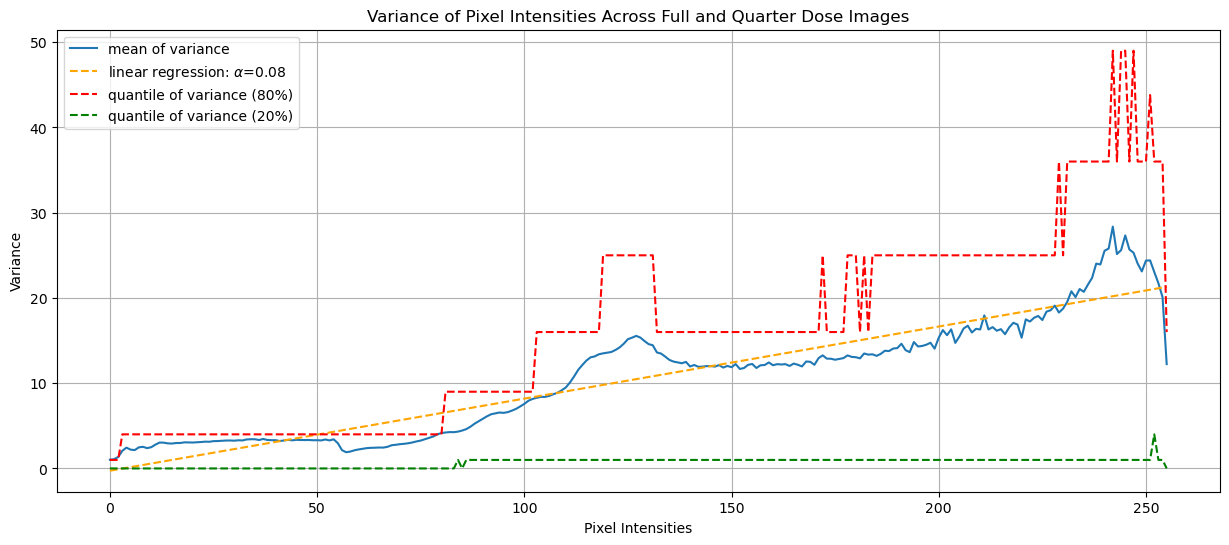

In [6]:
var_dict_mean, var_dict_q2, var_dict_q8, noise_density_distribution, slope = l506.noise_stat_analysis(plot=True)

## Advanced Noise Analysis

Since basic analysis have shown poor results, we performed a more advance noise analysis based on the following paper:

[1] *Realistic simulation of reduced-dose CT with noise modeling and sinogram synthesis using DICOM CT images*, Chang Won Kim & Jong Hyo Kim [(link)](https://aapm.onlinelibrary.wiley.com/doi/pdf/10.1118/1.4830431)

In [14]:
# Select one image pair to test the noise in sinogram level
img_f, img_q = l506_fd.imgs[0].pil, l506_qd.imgs[0].pil
img_f, img_q = np.array(img_f, dtype=np.uint8), np.array(img_q, dtype=np.uint8)

In [169]:
sino_f = ct_to_sino(img=img_f, angles=512)
sino_q = ct_to_sino(img=img_q, angles=512)
reconstructed_ct_f = sino_to_ct(sino=sino_f)
reconstructed_ct_q = sino_to_ct(sino=sino_q)

sino_f_noised = poisson_gaussian(image=torch.tensor(sino_f), var=0, alpha=0.005).numpy()
noised_img_f = sino_to_ct(sino=sino_f_noised)

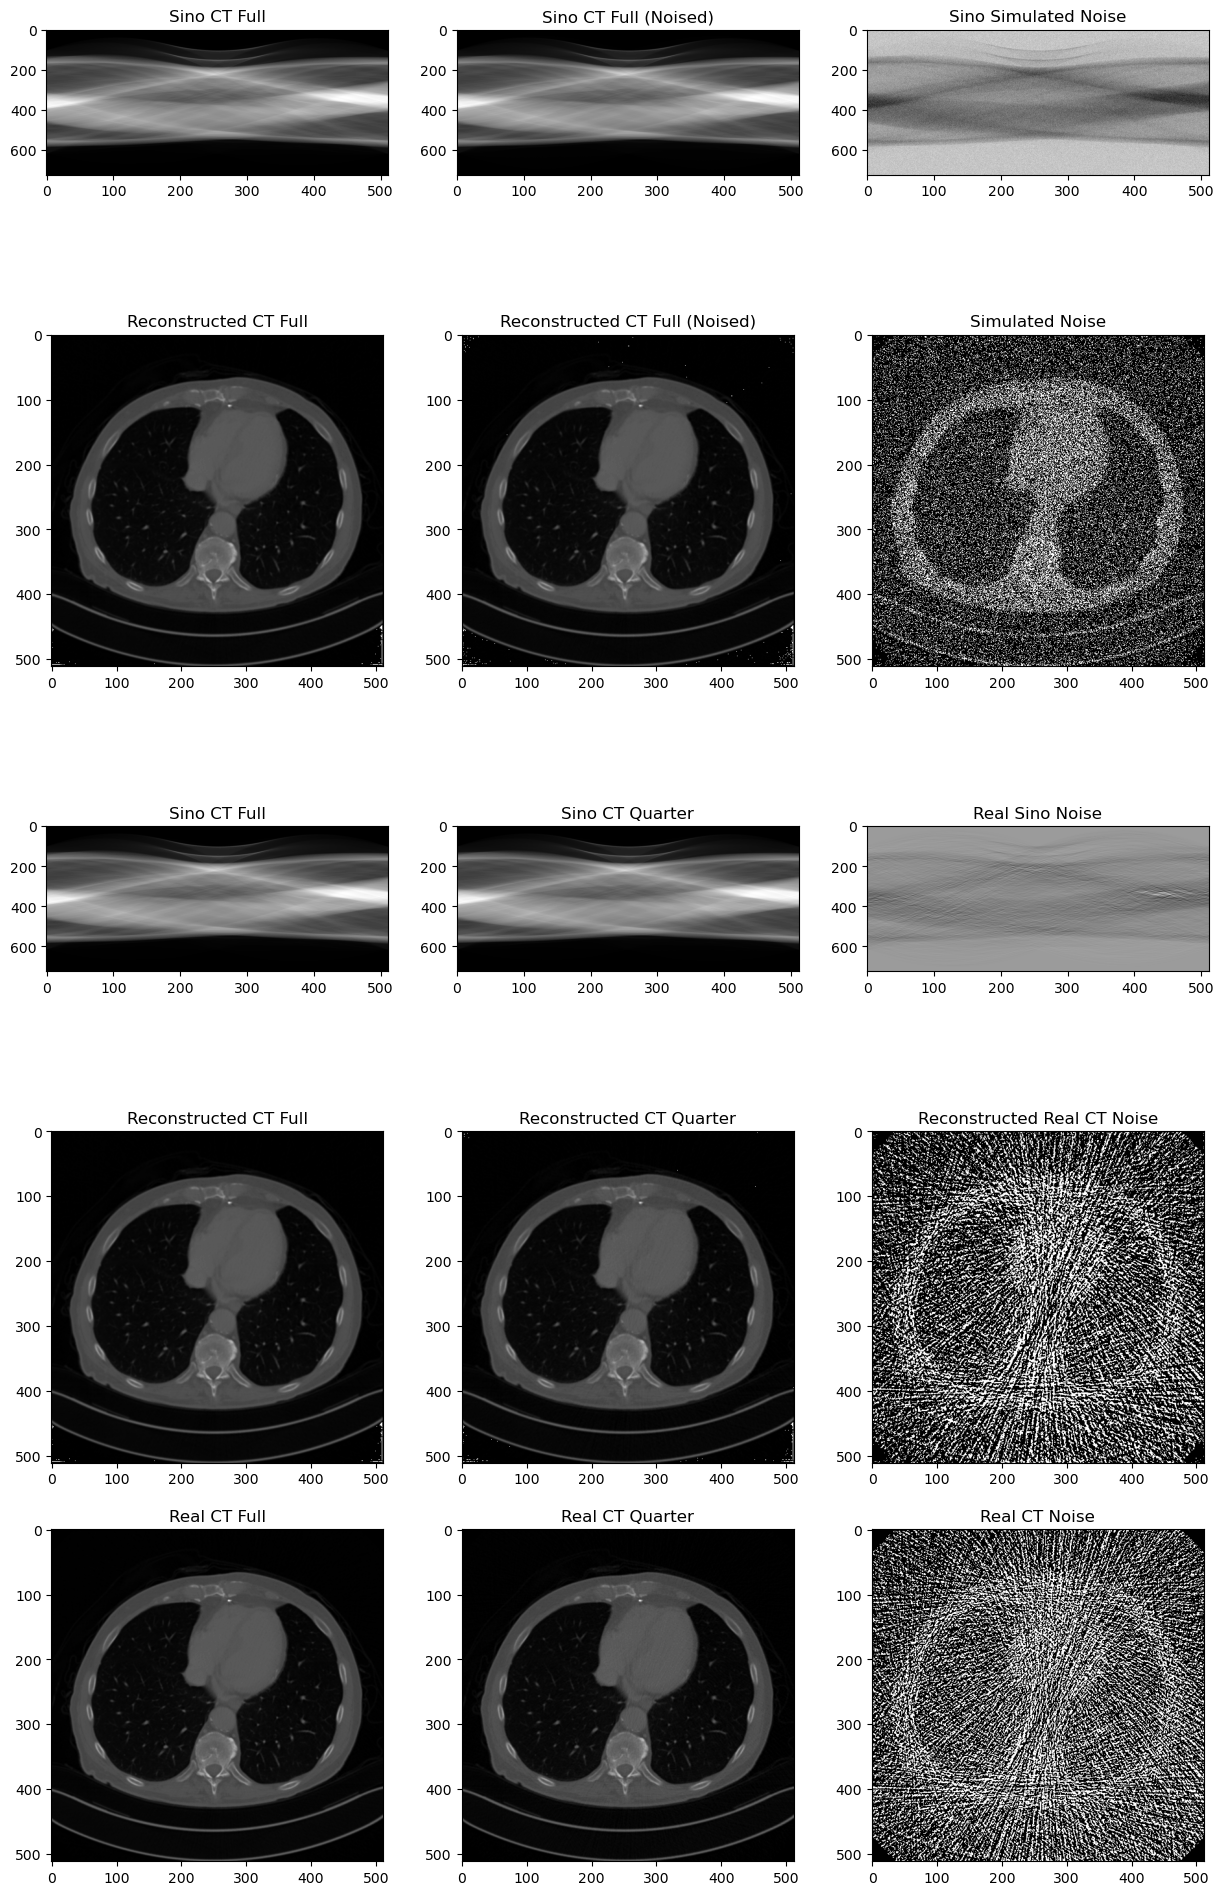

In [180]:
fig, axs = plt.subplots(5, 3, figsize=(15, 25))

axs[0][0].imshow(sino_f, aspect=0.3, cmap='grey')
axs[0][0].set_title('Sino CT Full')
axs[0][1].imshow(sino_f_noised, aspect=0.3, cmap='grey')
axs[0][1].set_title('Sino CT Full (Noised)')
axs[0][2].imshow(sino_f-sino_f_noised, aspect=0.3, cmap='grey')
axs[0][2].set_title('Sino Simulated Noise')

axs[1][0].imshow(reconstructed_ct_f, cmap='grey')
axs[1][0].set_title('Reconstructed CT Full')
axs[1][1].imshow(noised_img_f, cmap='grey')
axs[1][1].set_title('Reconstructed CT Full (Noised)')
axs[1][2].imshow(reconstructed_ct_f-noised_img_f, cmap='grey')
axs[1][2].set_title('Simulated Noise')

axs[2][0].imshow(sino_f, aspect=0.3, cmap='grey')
axs[2][0].set_title('Sino CT Full')
axs[2][1].imshow(sino_q, aspect=0.3, cmap='grey')
axs[2][1].set_title('Sino CT Quarter')
axs[2][2].imshow(sino_f-sino_q, aspect=0.3, cmap='grey')
axs[2][2].set_title('Real Sino Noise')

axs[3][0].imshow(reconstructed_ct_f, cmap='grey')
axs[3][0].set_title('Reconstructed CT Full')
axs[3][1].imshow(reconstructed_ct_q, cmap='grey')
axs[3][1].set_title('Reconstructed CT Quarter')
axs[3][2].imshow(reconstructed_ct_f-reconstructed_ct_q, cmap='grey')
axs[3][2].set_title('Reconstructed Real CT Noise')

axs[4][0].imshow(img_f, cmap='grey')
axs[4][0].set_title('Real CT Full')
axs[4][1].imshow(img_q, cmap='grey')
axs[4][1].set_title('Real CT Quarter')
axs[4][2].imshow(img_f-img_q, cmap='grey')
axs[4][2].set_title('Real CT Noise')

plt.show()

In [176]:
np.max(sino_f.dtype)

dtype('float64')

In [179]:
# Define the original array
original_array = np.array([0, 2, 10, 90])

# Calculate the minimum and maximum values in the original array
min_val = np.min(original_array)
max_val = np.max(original_array)

# Scale the values to the 0-255 range while maintaining ratios
scaled_array = ((original_array - min_val) / (max_val - min_val)) * 255

# Round the scaled values to integers
scaled_array = np.round(scaled_array).astype(int)

print(scaled_array)

[  0   6  28 255]


In [142]:
m = torch.poisson(torch.tensor([1000., 10.]))
m

tensor([1017.,   13.])

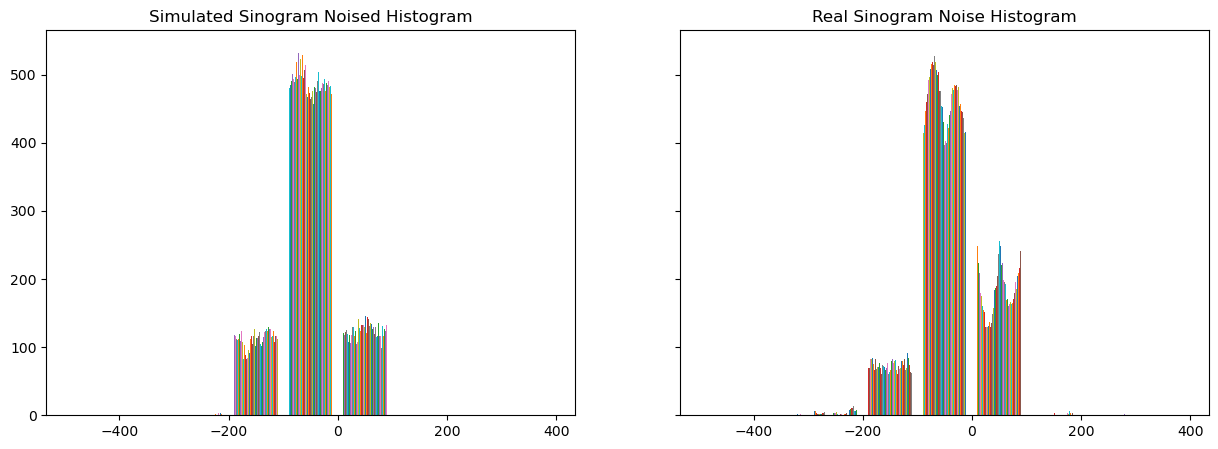

In [163]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)

bins = np.linspace(start=-500, stop=400, num=10)
axs[0].hist(sino_f-sino_f_noised, bins=bins)
axs[0].set_title('Simulated Sinogram Noised Histogram')
axs[1].hist(sino_f-sino_q, bins=bins)
axs[1].set_title('Real Sinogram Noise Histogram')


plt.show()

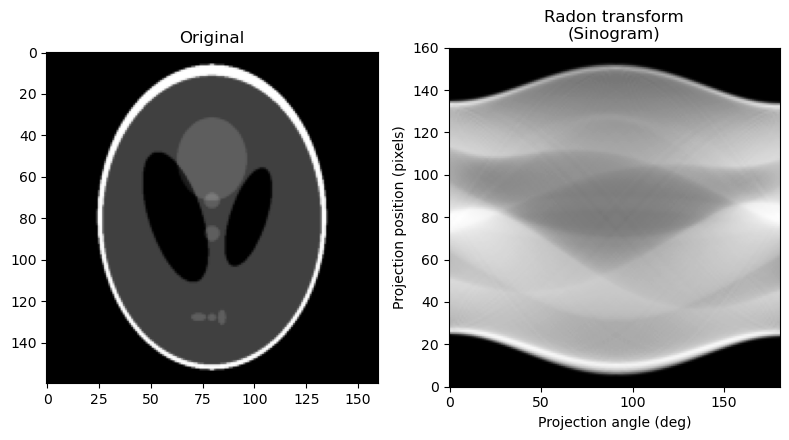

In [29]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale

image = shepp_logan_phantom()
image = rescale(image, scale=0.4, mode='reflect', channel_axis=None)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))

ax1.set_title("Original")
ax1.imshow(image, cmap=plt.cm.Greys_r)

theta = np.linspace(0.0, 180.0, max(image.shape), endpoint=False)
sinogram = radon(image, theta=theta, preserve_range=True)
dx, dy = 0.5 * 180.0 / max(image.shape), 0.5 / sinogram.shape[0]
ax2.set_title("Radon transform\n(Sinogram)")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
ax2.imshow(
    sinogram,
    cmap=plt.cm.Greys_r,
    extent=(-dx, 180.0 + dx, -dy, sinogram.shape[0] + dy),
    aspect='auto',
)

fig.tight_layout()
plt.show()

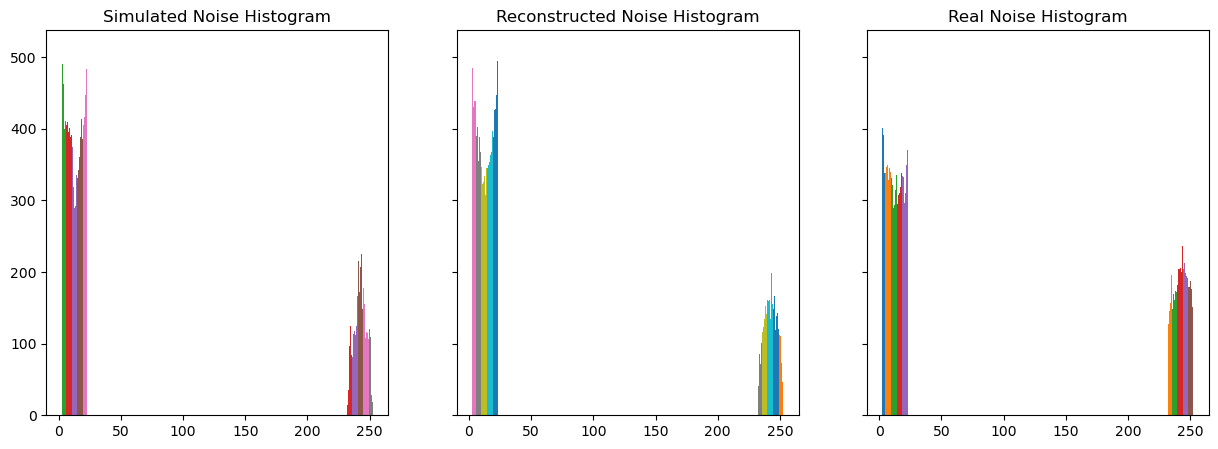

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

axs[0].hist(reconstructed_ct_f-noised_img_f)
axs[0].set_title('Simulated Noise Histogram')
axs[1].hist(reconstructed_ct_f-reconstructed_ct_q)
axs[1].set_title('Reconstructed Noise Histogram')
axs[2].hist(img_f-img_q)
axs[2].set_title('Real Noise Histogram')

plt.show()

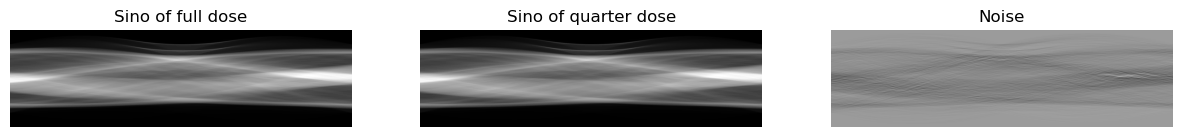

In [83]:
import skimage as ski

sino_f = ski.transform.radon(img_f, theta=np.linspace(0, 180, 512), circle=False, preserve_range=True)
sino_q = ski.transform.radon(img_q, theta=np.linspace(0, 180, 512), circle=False, preserve_range=True)

noise = sino_f - sino_q

plt.figure(figsize=(15, 10))

plt.subplot(1,3,1)
plt.imshow(sino_f, aspect=0.2, cmap='grey')
plt.title("Sino of full dose")
plt.axis('off');

plt.subplot(1,3,2)
plt.imshow(sino_q, aspect=0.2, cmap='grey')
plt.title("Sino of quarter dose")
plt.axis('off');

plt.subplot(1,3,3)
plt.imshow(noise, aspect=0.2, cmap='grey')
plt.title("Noise")
plt.axis('off');

plt.show()

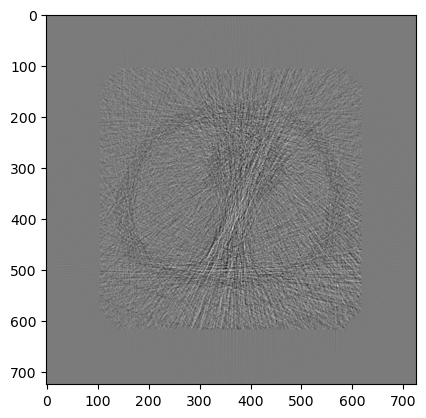

In [84]:
from PIL import Image

inversed_img_f = ski.transform.iradon(sino_f, preserve_range=True)
inversed_img_q = ski.transform.iradon(sino_q, preserve_range=True)
inversed_noise = inversed_img_f - inversed_img_q

plt.imshow(inversed_noise, cmap='grey')
plt.show()

In [85]:
inversed_noise.shape

(725, 725)

In [130]:
inversed_noise = Image.fromarray(inversed_noise)
inversed_img_f = Image.fromarray(inversed_img_f)
inversed_img_q = Image.fromarray(inversed_img_q)

inversed_img_f.show()